In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import array as arr
from timeit import default_timer as timer

In [ ]:
np.random.seed(1000)
A = np.random.randn(1000,10)
xb = np.array([np.random.uniform(-i-1,-i) if i%2 else np.random.uniform(i,i+1) for i in range(1,11)]).reshape(-1,1)
err = np.random.randn(1000,1)
y  = A@xb+err

In [ ]:
def evalf(x):
  return 0.5*np.linalg.norm(A@x-y)**2

def evalg(x):
  
  return ((A@x-y).T@A).T

def evalh(x):
   return A.T@A

In [ ]:
def compute_B_k(B,sk,yk):
  yk = yk.reshape(-1,1)
  sk = sk.reshape(-1,1)
  mk = 1/(yk.T@sk)
  I = np.eye(len(B))
  return (I - mk*sk@yk.T)@B@(I - mk*yk@sk.T) + mk*sk@sk.T

def compute_steplength_backtracking_scaled_direction(x, gradf, p, alpha_start, rho=0.5, gamma=0.5): #add appropriate arguments to the function 
  assert type(x) is np.ndarray  
  assert type(gradf) is np.ndarray 
  assert type(p) is np.ndarray 
  assert alpha_start>=0.
  assert type(rho) is float and rho>=0
  assert type(gamma) is float and gamma>=0

  alp = alpha_start
  #x = np.array(x,dtype='float64')
  while evalf(x + np.multiply(alp,p)) > evalf(x) + gamma*alp*gradf.T@p:
    alp *= rho
  return alp


def find_minimizer_gdscaling(start_x, tol,B,alpha=0.9,rho=0.5,gamma=0.5):
  #Input: start_x is a numpy array of size 2, tol denotes the tolerance and is a positive float value
  assert type(start_x) is np.ndarray  #do not allow arbitrary arguments 
  assert type(tol) is float and tol>=0 
  x = start_x
  k = 0
  xv = []

  while np.linalg.norm(evalg(x)) > tol:
    xv.append(x)
    p = -B@evalg(x)
    step = compute_steplength_backtracking_scaled_direction(x,evalg(x),p,alpha,rho,gamma)
    x0 = x 
    x = x + np.multiply(step,p)
    k+= 1
    yk = evalg(x) - evalg(x0)
    sk = x - x0
    B = compute_B_k(B,sk,yk)
    
    if k%1000 == 0:
      print(f'Iteration:{k}, min value:{evalf(x)}, gradient norm:{np.linalg.norm(evalg(x))}')     
  

  print(f'Iteration:{k}, min value:{evalf(x)}, gradient norm:{np.linalg.norm(evalg(x))}')
  return x,evalf(x),k,xv  


def find_minimizer_newton(start_x, tol,step=1):
  #Input: start_x is a numpy array of size 2, tol denotes the tolerance and is a positive float value
   #do not allow arbitrary arguments 
  assert type(tol) is float and tol>=0 
  x = start_x
  k = 0
  xv = []
  gr = evalg(x)

  D = np.linalg.inv(evalh(x))


  while np.linalg.norm(gr) > tol:
    xv.append(x)
    
    gr = evalg(x)
    p = -D@gr
    alp = compute_steplength_backtracking_scaled_direction(x,evalg(x),p,step,0.5,0.5)
    x =x + np.multiply(alp,p)
    k+= 1
    if k%10==0:
      print(f'Iteration:{k}, min value:{evalf(x)}, gradient norm:{np.linalg.norm(gr)}')

    
  print(f'Iteration:{k}, min value:{evalf(x)}, gradient norm:{np.linalg.norm(gr)}')
  return x,evalf(x),k,xv  

In [ ]:
X0 = np.array([0]*10,dtype='float64').reshape(-1,1)

## 2)
### Newton's method

In [ ]:
t1 = timer()
x1,fx1,k1,xv1 = find_minimizer_newton(X0,1e-4,0.99)
t2 = timer()

Iteration:6, min value:505.647329524551, gradient norm:2.353864228623605e-06


In [ ]:
print('The value of xbar is',xb.T)
print('The estimated value of xbar (x*) is ',x1.T)

The value of xbar is [[-1.06258705  2.94307072 -3.34150552  4.58252615 -5.75947573  6.93512469
  -7.61893094  8.16818187 -9.2179964  10.00022174]]
The estimated value of xbar (x*) is  [[-1.04982253  2.95189743 -3.34298192  4.60956007 -5.71176195  6.89877618
  -7.62879358  8.16821112 -9.22221199 10.05669293]]


In [ ]:
(xb-x1).flatten()

array([-1.27645176e-02, -8.82671463e-03,  1.47639751e-03, -2.70339195e-02,
       -4.77137801e-02,  3.63485143e-02,  9.86263846e-03, -2.92420236e-05,
        4.21559565e-03, -5.64711819e-02])

We see that error in each component of x is at most of the order $10^{-2}$

In [ ]:
convn = [i - x1 for i in xv1]
lognorm1 = [np.log(np.linalg.norm(convn[i])) for i in range(k1)]
logfxk = [np.log(abs(evalf(i)-fx1)) for i in xv1]

<ipython-input-9-8dec63bd323a>:3: RuntimeWarning: divide by zero encountered in log
  logfxk = [np.log(abs(evalf(i)-fx1)) for i in xv1]


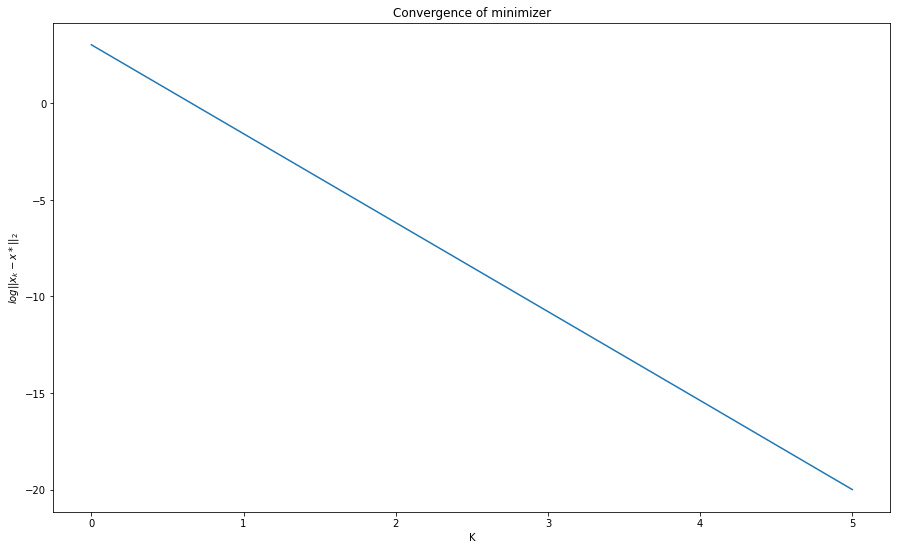

In [ ]:
plt.figure(figsize=(15,9))
plt.plot(range(k1),lognorm1)
plt.ylabel('$log||x_k - x*||_2$')
plt.xlabel('K')
plt.title('Convergence of minimizer')
plt.show()

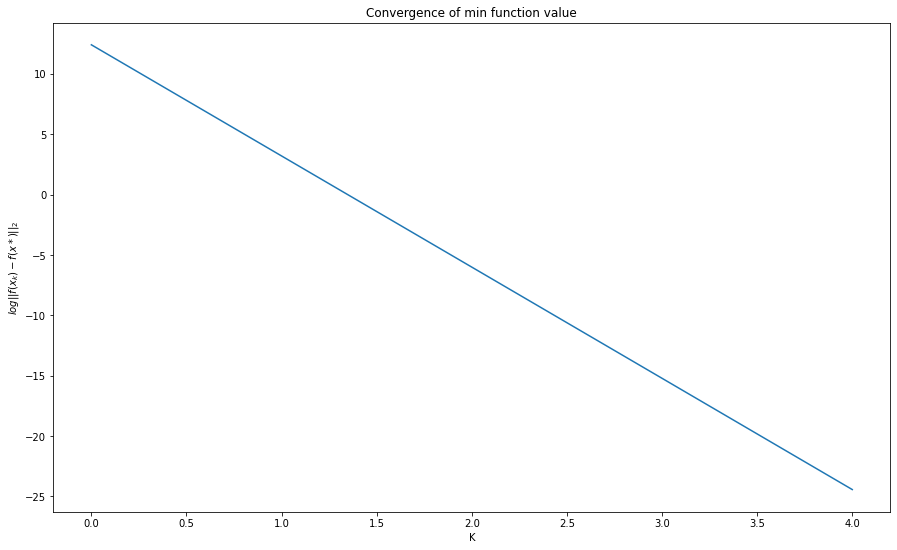

In [ ]:
plt.figure(figsize=(15,9))
plt.plot(range(k1),logfxk)
plt.ylabel('$log||f(x_k) - f(x*)||_2$')
plt.xlabel('K')
plt.title('Convergence of min function value')
plt.show()

The plots above indicate that the convergence in newtons method is Q-linear

## 3)

### BFGS method

In [ ]:
t3 = timer()
x2,fx2,k2,xv2 = find_minimizer_gdscaling(X0,1e-4,np.eye(10),0.99)
t4 = timer()

Iteration:18, min value:505.64732952455125, gradient norm:2.5401287742796014e-06


In [ ]:
print('The value of xbar is',xb.T)
print('The estimated value of xbar (x*) is ',x2.T)

The value of xbar is [[-1.06258705  2.94307072 -3.34150552  4.58252615 -5.75947573  6.93512469
  -7.61893094  8.16818187 -9.2179964  10.00022174]]
The estimated value of xbar (x*) is  [[-1.04982253  2.95189743 -3.34298192  4.60956007 -5.71176195  6.89877618
  -7.62879358  8.16821111 -9.22221199 10.05669293]]


In [ ]:
(xb-x2).flatten()

array([-1.27645182e-02, -8.82671470e-03,  1.47639682e-03, -2.70339193e-02,
       -4.77137807e-02,  3.63485153e-02,  9.86263761e-03, -2.92409047e-05,
        4.21559492e-03, -5.64711816e-02])

We see that error in each component of x is at most of the order $10^{-2}$

In [ ]:
convn2 = [i - x2 for i in xv2]
lognorm2 = [np.log(np.linalg.norm(convn2[i])) for i in range(k2)]
logfxk2 = [np.log(abs(evalf(i)-fx2)) for i in xv2]

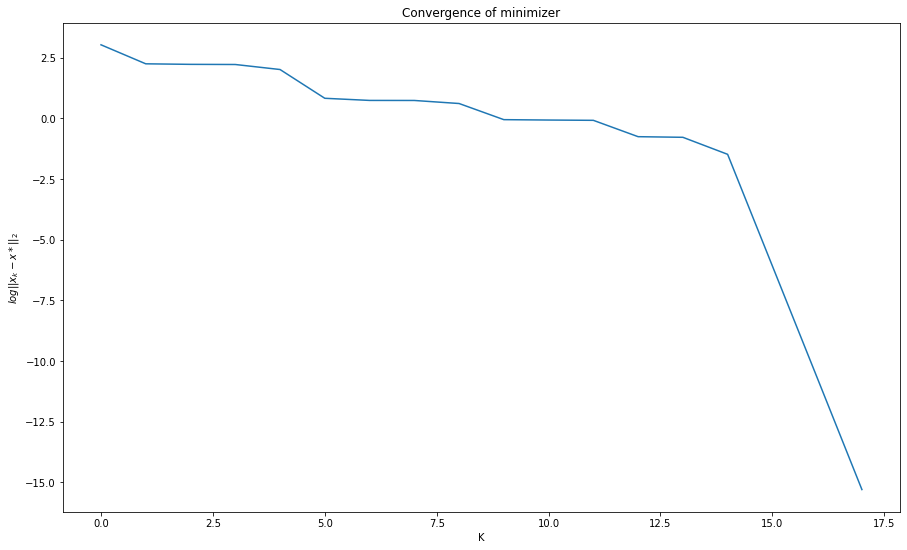

In [ ]:
plt.figure(figsize=(15,9))
plt.plot(range(k2),lognorm2)
plt.ylabel('$log||x_k - x*||_2$')
plt.xlabel('K')
plt.title('Convergence of minimizer')
plt.show()

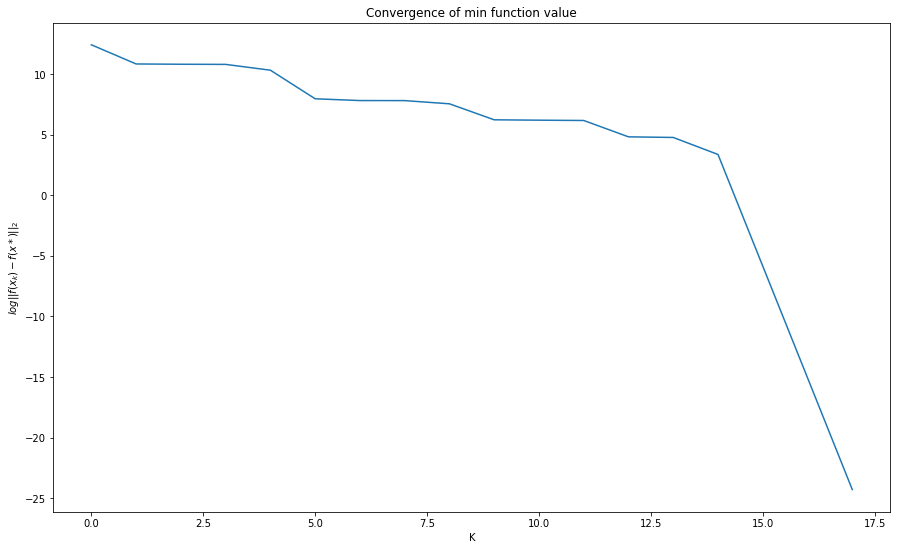

In [ ]:
plt.figure(figsize=(15,9))
plt.plot(range(k2),logfxk2)
plt.ylabel('$log||f(x_k) - f(x*)||_2$')
plt.xlabel('K')
plt.title('Convergence of min function value')
plt.show()

The plot suggest that convergence is linear, but there arent enough datapoints to be conclusive. 

Even if we reduce tolerance, the number of iterations dont increase by much, and the alfgorithm stops converging after a certain limit. Hence we cant properly comment on convergence of bfgs for this particular problem

## 4)

In [ ]:
print('Time taken by newtons method is %f seconds'%(t2-t1))
print('Time taken by BFGS method is %f seconds'%(t4-t3))

Time taken by newtons method is 0.016778 seconds
Time taken by BFGS method is 0.049426 seconds


In [ ]:
x2-x1

array([[ 6.05636652e-10],
       [ 7.29403205e-11],
       [ 6.88715307e-10],
       [-2.23167262e-10],
       [ 6.69042599e-10],
       [-1.07271436e-09],
       [ 8.50503667e-10],
       [-1.11889520e-09],
       [ 7.33347605e-10],
       [-2.88887136e-10]])

The min objective function value is same for both methods upto 13 decimal places, and the difference in estimation of each component of x is approx of the order $10^{-10}$. We see that BFGS method took 7x-8x the time required for newtons method.

The plot of log(||$x_k - x*$||) suggested that convergence of newtons method was Q-linear, while convergence of BFGS also seemed to get linear (if we consider k = 14 as sufficiently large)

Time taken by newtons method is 0.016778 seconds
Time taken by BFGS method is 0.049426 seconds
Both methods are very quick.

Still BFGS is faster,Because in BFGS we are not finding inverse of hessian at each iteration ,while in newton we are computing inverse in each iteration but newton is also fast since hessian is independent of new X.

